# AWS SQL Database with CloudWatch and SNS Integration

This notebook demonstrates how to create a SQL database on AWS RDS, manage it using SQLAlchemy, and set up AWS services such as SNS and Lambda for notification and execution based on database events.

## Project Objectives
- Connect to an AWS RDS MySQL database using SQLAlchemy.
- Create a table to store movie data and insert sample entries.
- Use SQL `COALESCE` function to handle missing data in queries.
- Set up SNS to send notifications when certain conditions are met.
- Deploy a Lambda function that can be invoked based on database events.


2024-10-12 07:42:34,873 - INFO - Rule for 13.71.3.104/32 on port 3306 already exists. Skipping update.
2024-10-12 07:42:34,875 - INFO - Database engine created successfully.
2024-10-12 07:42:37,845 - INFO - Inserted movie: The Dark Knight, Genre: Action, Year: 2008
2024-10-12 07:42:38,439 - INFO - Inserted movie: Inception, Genre: Sci-Fi, Year: 2010
2024-10-12 07:42:39,032 - INFO - Inserted movie: Forrest Gump, Genre: Drama, Year: 1994
2024-10-12 07:42:39,624 - INFO - Inserted movie: The Matrix, Genre: Sci-Fi, Year: 1999
2024-10-12 07:42:39,825 - INFO - Total number of movies in the database: 153
2024-10-12 07:42:40,663 - INFO - Published SNS message: The total movie count has exceeded the threshold: 153 movies. (Message ID: eae63cce-d3fe-5835-a448-634af94eacb0)
2024-10-12 07:42:41,314 - INFO - Invoked Lambda function: lambdatrustee, Response: 202


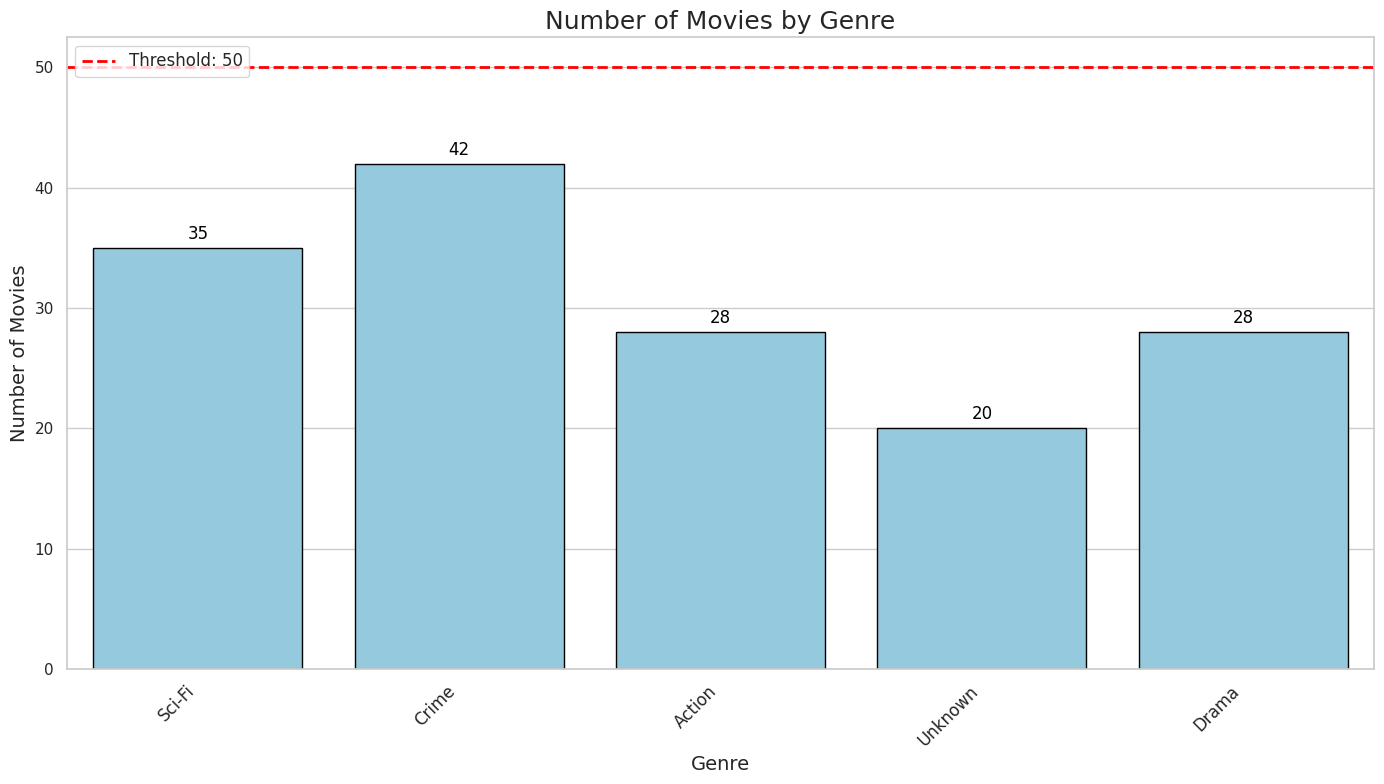

2024-10-12 07:42:41,846 - INFO - Improved plot generated for movies by genre with threshold explanation.


In [14]:
import os
import logging
import boto3
import pandas as pd
from sqlalchemy import create_engine, Column, Integer, String, Sequence, text
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy.exc import SQLAlchemyError
import matplotlib.pyplot as plt
import seaborn as sns

# Logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Database configuration
DB_USER = 'admin'
DB_PASSWORD = 'passwordtrustee'
DB_HOST = 'database-1.cry22yg4masb.us-east-1.rds.amazonaws.com'
DB_PORT = 3306  # Default MySQL port
DB_NAME = 'databasetrustee'

# AWS SNS and Lambda configuration
SNS_TOPIC_ARN = 'arn:aws:sns:us-east-1:171304843553:topictrustee'
LAMBDA_FUNCTION_NAME = 'lambdatrustee'
AWS_REGION = 'us-east-1'  # Specify your region here

# Security group ID
SECURITY_GROUP_ID = 'sg-0b86bbfa3668bb2f7'

# Create SQLAlchemy base class
Base = declarative_base()

# SQLAlchemy ORM Model for Movies
class Movie(Base):
    __tablename__ = 'movies'
    id = Column(Integer, Sequence('movie_id_seq'), primary_key=True)
    title = Column(String(255), nullable=False)
    genre = Column(String(50), nullable=True)
    year = Column(Integer, nullable=True)

# Create a database connection
def create_db_engine():
    try:
        engine = create_engine(f'mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')
        logging.info("Database engine created successfully.")
        return engine
    except Exception as e:
        logging.error(f"Error creating database engine: {e}")
        raise

# Insert movie function with validation
def insert_movie(session, title, genre=None, year=None):
    try:
        if not title or not isinstance(title, str):
            logging.error("Invalid title provided for the movie.")
            raise ValueError("Title must be a non-empty string.")
        new_movie = Movie(title=title, genre=genre, year=year)
        session.add(new_movie)
        session.commit()
        logging.info(f"Inserted movie: {title}, Genre: {genre}, Year: {year}")
    except ValueError as ve:
        logging.error(f"Value error: {ve}")
        session.rollback()
    except SQLAlchemyError as e:
        logging.error(f"Error inserting movie into database: {e}")
        session.rollback()
    except Exception as e:
        logging.error(f"Unexpected error: {e}")
        session.rollback()

# COALESCE query demonstration
def fetch_movies_with_coalesce(session):
    try:
        query = text("SELECT id, title, COALESCE(genre, 'Unknown') AS genre, COALESCE(year, 0) AS year FROM movies")
        result = session.execute(query).fetchall()
        logging.info("Fetched movies with COALESCE:")
        for row in result:
            logging.info(row)
    except SQLAlchemyError as e:
        logging.error(f"Error fetching movies: {e}")

# Publish SNS message
def publish_sns_message(movie_count):
    try:
        sns_client = boto3.client('sns', region_name=AWS_REGION)  # Specify your region here
        message = f'The total movie count has exceeded the threshold: {movie_count} movies.'
        response = sns_client.publish(
            TopicArn=SNS_TOPIC_ARN,
            Message=message
        )
        logging.info(f"Published SNS message: {message} (Message ID: {response['MessageId']})")
    except Exception as e:
        logging.error(f"Error publishing SNS message: {e}")

# Invoke Lambda function
def invoke_lambda(movie_count):
    try:
        lambda_client = boto3.client('lambda', region_name=AWS_REGION)  # Specify your region here
        response = lambda_client.invoke(
            FunctionName=LAMBDA_FUNCTION_NAME,
            InvocationType='Event',
            Payload=str(movie_count).encode('utf-8')
        )
        logging.info(f"Invoked Lambda function: {LAMBDA_FUNCTION_NAME}, Response: {response['StatusCode']}")
    except Exception as e:
        logging.error(f"Error invoking Lambda function: {e}")

# Improved Plotting function for movies by genre with detailed threshold explanation
def plot_movies_by_genre(session, threshold=5):
    try:
        query = text("SELECT genre, COUNT(*) AS count FROM movies GROUP BY genre")
        result = session.execute(query).fetchall()
        
        # Convert results to a DataFrame
        df = pd.DataFrame(result, columns=['Genre', 'Count'])
        
        # Replace None values in Genre with 'Unknown'
        df['Genre'] = df['Genre'].fillna('Unknown')

        # Set Seaborn style
        sns.set(style="whitegrid", palette="muted")

        # Create a figure and axes for the plot
        plt.figure(figsize=(14, 8))

        # Plot with Seaborn barplot
        ax = sns.barplot(x='Genre', y='Count', data=df, color='skyblue', edgecolor='black')

        # Add a horizontal line for the threshold
        plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold: {threshold}', linewidth=2)

        # Annotate each bar with its value
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        fontsize=12, color='black', 
                        xytext=(0, 10), textcoords='offset points')

        # Highlight the bars above the threshold
        for p in ax.patches:
            if p.get_height() > threshold:
                p.set_facecolor('orange')

        # Title and labels
        plt.title('Number of Movies by Genre', fontsize=18)
        plt.xlabel('Genre', fontsize=14)
        plt.ylabel('Number of Movies', fontsize=14)
        
        # Rotate x-axis labels
        plt.xticks(rotation=45, ha='right', fontsize=12)
        
        # Add a legend
        plt.legend(loc='upper left', fontsize=12)
        
        # Tight layout for better spacing
        plt.tight_layout()

        # Save the plot as a PNG file
        plt.savefig('movies_by_genre_with_threshold_explanation.png', bbox_inches='tight')
        plt.show()  # Display the plot
        logging.info("Improved plot generated for movies by genre with threshold explanation.")
    except Exception as e:
        logging.error(f"Error generating plot: {e}")

# Update Security Group with Codespace IP
def update_security_group(ip_address):
    try:
        ec2_client = boto3.client('ec2', region_name=AWS_REGION)

        # Check if the rule already exists
        response = ec2_client.describe_security_groups(GroupIds=[SECURITY_GROUP_ID])
        security_group = response['SecurityGroups'][0]

        # Check existing inbound rules
        existing_rules = security_group.get('IpPermissions', [])
        rule_exists = False
        for rule in existing_rules:
            if rule['IpProtocol'] == 'tcp' and rule['FromPort'] == 3306 and rule['ToPort'] == 3306:
                for ip_range in rule.get('IpRanges', []):
                    if ip_range['CidrIp'] == f'{ip_address}/32':
                        rule_exists = True
                        break
            if rule_exists:
                break

        # If rule doesn't exist, add it
        if not rule_exists:
            ec2_client.authorize_security_group_ingress(
                GroupId=SECURITY_GROUP_ID,  # Security Group ID
                IpPermissions=[{
                    'IpProtocol': 'tcp',
                    'FromPort': 3306,
                    'ToPort': 3306,
                    'IpRanges': [{'CidrIp': f'{ip_address}/32'}]
                }]
            )
            logging.info(f"Security group updated to allow access from {ip_address}/32 on port 3306.")
        else:
            logging.info(f"Rule for {ip_address}/32 on port 3306 already exists. Skipping update.")

    except Exception as e:
        logging.error(f"Error updating security group: {e}")

# Main logic to connect to DB and check movie count
def main():
    # Get current Codespace IP and update security group right at the start
    current_ip = '13.71.3.104'  # This would ideally be dynamically fetched
    update_security_group(current_ip)

    engine = create_db_engine()
    Session = sessionmaker(bind=engine)
    try:
        with Session() as session:
            # Insert some test movies
            test_movies = [
                {"title": "The Dark Knight", "genre": "Action", "year": 2008},
                {"title": "Inception", "genre": "Sci-Fi", "year": 2010},
                {"title": "Forrest Gump", "genre": "Drama", "year": 1994},
                {"title": "The Matrix", "genre": "Sci-Fi", "year": 1999},
            ]
            for movie in test_movies:
                insert_movie(session, **movie)

            # Fetch total number of movies
            movie_count = session.query(Movie).count()
            logging.info(f"Total number of movies in the database: {movie_count}")

            # If movie count exceeds threshold, publish SNS message and invoke Lambda
            if movie_count > 100:
                publish_sns_message(movie_count)
                invoke_lambda(movie_count)

            # Generate plot with threshold explanation
            plot_movies_by_genre(session, threshold=50)

    except Exception as e:
        logging.error(f"Error in main process: {e}")

if __name__ == '__main__':
    main()


## Instructions to Run the Notebook

1. **Set Up AWS Credentials**: Ensure you have AWS credentials set up in your environment. You can do this using the AWS CLI or by creating a `~/.aws/credentials` file.

2. **Modify Database Credentials**: Update the `DB_USER`, `DB_PASSWORD`, `DB_HOST`, and `DB_NAME` variables with your RDS instance details.

3. **SNS and Lambda Setup**: Make sure you have created an SNS topic and a Lambda function in your AWS account. Update the `SNS_TOPIC_ARN` and `LAMBDA_FUNCTION_NAME` variables accordingly.

4. **Install Dependencies**: Ensure you have the required packages installed. Run the following command in your terminal:

   ```bash
   pip install sqlalchemy pymysql boto3
   ```

5. **Run the Notebook**: Execute each cell in the notebook. Monitor the logs for detailed information about the database operations, SNS notifications, and Lambda invocations.

6. **Review Results**: Check your AWS SNS to see the messages published and AWS Lambda to see if it was invoked successfully.